### Description
This kaggle competition provides images (pathology scans), with an objective to develop an algorithm which can identify metastatic cancer cells from all available scans. There are 220k images available for training and the competitions expects us to submit prediction for 57.5k test images.

To put it simply, this is image classification problem. Traditionally CNN has been used for image classification, but recently (from 2021), transformers has started to take over CNN approachs.So via this assignment, I would explore vision transformers along with CNN architecture for image classification.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

2025-06-29 17:03:35.543105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751216615.870478  518775 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751216616.002202  518775 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751216616.917294  518775 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751216616.917357  518775 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751216616.917361  518775 computation_placer.cc:177] computation placer alr

In [2]:
IMAGE_DIR = 'data/train/' # Path to your folder containing all images
CSV_FILE = "data/train_labels.csv" # Path to your CSV file

IMG_HEIGHT = 96
IMG_WIDTH = 96
CHANNELS = 3 # 3 for RGB, 1 for grayscale
BATCH_SIZE = 32     # Batch size for training
AUTOTUNE = tf.data.AUTOTUNE # For optimizing data pipeline performance

# --- ViT Specific Configuration ---
PATCH_SIZE = 16  # Size of the square patches (e.g., 16x16 pixels)
NUM_PATCHES = (IMG_HEIGHT // PATCH_SIZE) * (IMG_WIDTH // PATCH_SIZE)
PROJECTION_DIM = 64 # Dimension for patch embeddings
NUM_HEADS = 4       # Number of attention heads in Transformer
TRANSFORMER_LAYERS = 4 # Number of Transformer blocks
MLP_HEAD_UNITS = [256, 1] # MLP head units for binary classification (1 for sigmoid)

In [3]:
df = pd.read_csv(CSV_FILE)
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Basic EDA
Checking distribution of label to check if labels are skewed or have high imbalance.

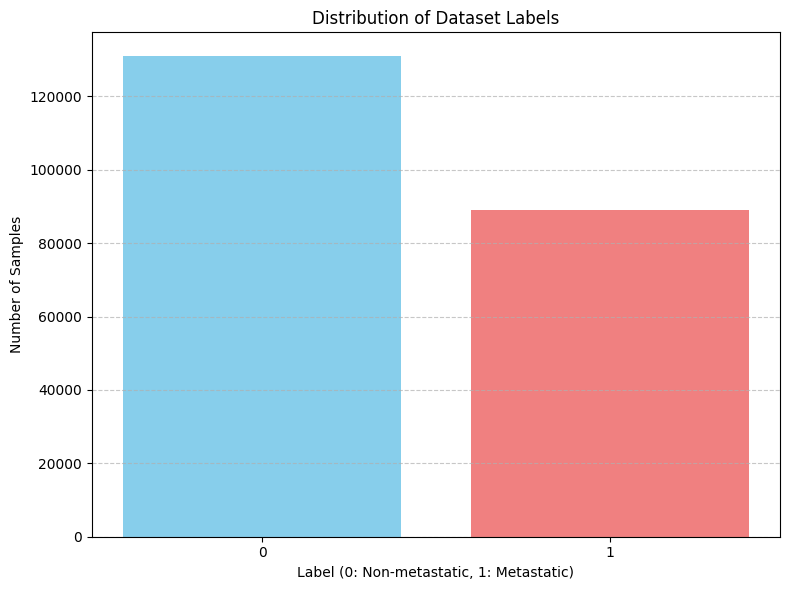

In [4]:
label_counts = df['label'].value_counts()

# Sort the index to ensure consistent order (e.g., 0 then 1)
label_counts = label_counts.sort_index()

# Calculate percentages for better understanding
total_samples = label_counts.sum()
label_percentages = (label_counts / total_samples) * 100
# --- Step 3: Create the Bar Chart ---
plt.figure(figsize=(8, 6))

# Plotting the bar chart
# label_counts.index will give you the label values (0, 1)
# label_counts.values will give you the counts for each label
bars = plt.bar(label_counts.index.astype(str), label_counts.values, color=['skyblue', 'lightcoral'])

# Adding labels and title
plt.title('Distribution of Dataset Labels')
plt.xlabel('Label (0: Non-metastatic, 1: Metastatic)')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0) # Keep x-axis labels horizontal

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Preparing data
Data preparation is same for both ViT (Vision transformer) and CNN based models which include reading image data using `tf.data.Dataset` followed by splitting data into training and validation set (80-20).

In [5]:
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
image_paths = [os.path.join(IMAGE_DIR, f"{filename}.tif") for filename in df['id']]
labels = df['label'].values

In [6]:
def load_and_preprocess_image_pil(filepath_tensor):
    """
    Loads an image using Pillow, resizes it, and normalizes pixel values.
    This function will be wrapped by tf.py_function.
    """
    # Convert TensorFlow string tensor to Python string
    filepath = filepath_tensor.numpy().decode('utf-8')

    try:
        img_pil = Image.open(filepath)

        # Convert to desired number of channels
        if CHANNELS == 3:
            # Ensure 3 channels (convert 'L' to 'RGB', or 'RGBA' to 'RGB')
            if img_pil.mode == 'L': # Grayscale
                img_pil = img_pil.convert('RGB')
            elif img_pil.mode == 'RGBA': # RGBA to RGB
                img_pil = img_pil.convert('RGB')
            elif img_pil.mode != 'RGB': # Any other mode, try converting to RGB
                 img_pil = img_pil.convert('RGB')
        elif CHANNELS == 1:
            # Ensure 1 channel (convert 'RGB' to 'L', 'RGBA' to 'L')
            if img_pil.mode in ['RGB', 'RGBA']:
                img_pil = img_pil.convert('L')
            elif img_pil.mode != 'L': # Any other mode, try converting to L
                img_pil = img_pil.convert('L')

        # Resize the image
        img_pil = img_pil.resize((IMG_WIDTH, IMG_HEIGHT), Image.LANCZOS) # LANCZOS is a high-quality filter

        # Convert to NumPy array
        img_np = np.array(img_pil)

        # Add channel dimension if it's missing (e.g., grayscale image might be (H, W))
        if img_np.ndim == 2:
            img_np = np.expand_dims(img_np, axis=-1) # Becomes (H, W, 1)

        # Ensure correct channel dimension matching CHANNELS variable
        if img_np.shape[-1] != CHANNELS:
            # This handles cases where Pillow's convert might result in different channels
            # than expected, though `convert` attempts to ensure it.
            # Fallback if there's still a mismatch.
            print(f"Warning: Image {filepath} has {img_np.shape[-1]} channels, but {CHANNELS} expected after Pillow conversion.")
            # Depending on error, you might need more specific handling here.
            # Forcing slice if it has more channels, or duplicating if fewer
            if img_np.shape[-1] > CHANNELS:
                img_np = img_np[:, :, :CHANNELS]
            elif img_np.shape[-1] < CHANNELS:
                # Basic fill if fewer channels (e.g., L to RGB if convert('RGB') failed)
                if img_np.shape[-1] == 1 and CHANNELS == 3:
                    img_np = np.repeat(img_np, 3, axis=-1)
                else:
                    raise ValueError(f"Cannot correctly adjust channels for {filepath}. Expected {CHANNELS}, got {img_np.shape[-1]}.")


        # Normalize pixel values to [0, 1]
        img_np = img_np.astype(np.float32) / 255.0

        return img_np

    except FileNotFoundError:
        print(f"Error: Image file not found at {filepath}. Skipping this image.")
        return np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.float32) # Return a blank image
    except Exception as e:
        print(f"Error processing image {filepath}: {e}. Skipping this image.")
        return np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.float32) # Return a blank image

In [7]:
def process_path_for_dataset(file_path_tensor, label_tensor):
    """
    Wrapper function for tf.data.Dataset.map to call the Pillow-based image loading.
    """
    image = tf.py_function(load_and_preprocess_image_pil, [file_path_tensor], tf.float32)
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    return image, label_tensor

# --- Step 3: Create TensorFlow Dataset utility function ---
def create_tf_dataset(dataframe, image_dir, batch_size, shuffle_buffer_size=1, prefetch_buffer_size=1, shuffle=True):
    image_paths = [os.path.join(image_dir, f"{filename}.tif") for filename in dataframe['id']]
    labels = dataframe['label'].values

    image_paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    labels_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int32))

    filepath_label_ds = tf.data.Dataset.zip((image_paths_ds, labels_ds))

    dataset = filepath_label_ds.map(process_path_for_dataset, num_parallel_calls=AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=prefetch_buffer_size) # Use provided prefetch_buffer_size
    return dataset

In [8]:
# --- Step 4: Split into Training and Validation DataFrames ---
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create datasets for training and validation
train_ds = create_tf_dataset(train_df, IMAGE_DIR, BATCH_SIZE,
                             shuffle_buffer_size=8, # Full shuffle for training
                             prefetch_buffer_size=AUTOTUNE,
                             shuffle=False)

val_ds = create_tf_dataset(val_df, IMAGE_DIR, BATCH_SIZE,
                           shuffle_buffer_size=1, # No shuffle needed for validation
                           prefetch_buffer_size=AUTOTUNE,
                           shuffle=False)

Training samples: 176020
Validation samples: 44005


I0000 00:00:1751216665.210454  518775 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



--- Optimized Verification of a Small Sample from the Streaming Dataset ---
Verification Image batch shape: (5, 96, 96, 3)
Verification Label batch shape: (5,)
Sample labels for verification: [0 0 0 0 1]


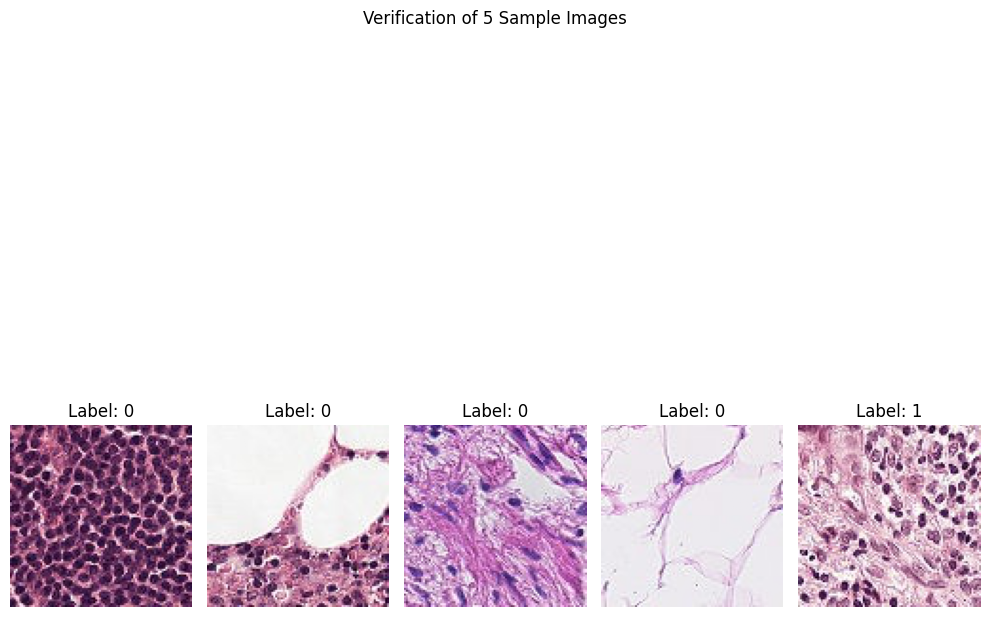

2025-06-29 17:04:27.442401: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# --- Step 5: Optimized Verification of a Small Number of Samples ---
print("\n--- Optimized Verification of a Small Sample from the Streaming Dataset ---")
VERIFY_COUNT = 5 # Number of samples to display

# Create a *dedicated, small* dataset for verification
verify_df = train_df.head(VERIFY_COUNT) # Take just the first N samples from the training set dataframe
if len(verify_df) == 0:
    print("No samples available in training DataFrame for verification. Check your CSV and image folder.")
else:
    verification_ds = create_tf_dataset(verify_df, IMAGE_DIR,
                                        batch_size=VERIFY_COUNT,
                                        shuffle_buffer_size=1,
                                        prefetch_buffer_size=1,
                                        shuffle=False).take(1) # Take only one batch

    # Iterate once over the verification dataset
    try:
        for image_batch, label_batch in verification_ds:
            print(f"Verification Image batch shape: {image_batch.shape}")
            print(f"Verification Label batch shape: {label_batch.shape}")
            print(f"Sample labels for verification: {label_batch.numpy()}")

            plt.figure(figsize=(10, 10))
            for i in range(image_batch.shape[0]): # Iterate up to the actual number of samples in the batch
                ax = plt.subplot(1, image_batch.shape[0], i + 1)
                display_img = image_batch[i].numpy()
                if CHANNELS == 1:
                    display_img = display_img.squeeze()
                    plt.imshow(display_img, cmap='gray')
                else:
                    plt.imshow(display_img)
                plt.title(f"Label: {label_batch[i].numpy()}")
                plt.axis("off")
            plt.suptitle(f"Verification of {image_batch.shape[0]} Sample Images")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
    except tf.errors.OutOfRangeError: # Catches if dataset is empty
        print("Verification dataset is empty or ran out of elements.")
    except Exception as e:
        print(f"An error occurred during verification: {e}")

### Vision transformers (ViT)
ViT decomposes an input image into a series of patches (rather than text into tokens), serializes each patch into a vector, and maps it to a smaller dimension with a single matrix multiplication. These vector embeddings are then processed by a transformer encoder as if they were token embeddings.
Source: https://en.wikipedia.org/wiki/Vision_transformer
Original Vision transformer - https://arxiv.org/abs/2010.11929

In [10]:
# --- Step 6: Implement Vision Transformer Architecture ---
print("\n--- Implementing Vision Transformer Architecture ---")

# 6.1 Patch Extraction Layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        # tf.image.extract_patches extracts non-overlapping patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # Flatten patches: (batch, num_patches_h, num_patches_w, patch_size*patch_size*channels)
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # (batch, num_patches, patch_dims)
        return patches

# 6.2 Patch Embedding Layer (Linear Projection + Positional Embedding)
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# 6.3 Vision Transformer Block (Multi-Head Self-Attention + MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


--- Implementing Vision Transformer Architecture ---


In [11]:
def create_vit_classifier():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

    # Create patches
    patches = Patches(PATCH_SIZE)(inputs)

    # Encode patches
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # Create multiple Transformer blocks
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-Head Self-Attention
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1) # Query, Key, Value are all x1
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=[PROJECTION_DIM * 2, PROJECTION_DIM], dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Classify outputs. We'll use Global Average Pooling over all patches.
    # Alternatives: Use a learnable [CLS] token and extract its embedding.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation) # Pool over the sequence of patches

    # MLP head for classification
    for units in MLP_HEAD_UNITS[:-1]:
        representation = layers.Dense(units, activation="relu")(representation)
        representation = layers.Dropout(0.5)(representation)

    # Output layer for binary classification
    outputs = layers.Dense(MLP_HEAD_UNITS[-1], activation="sigmoid")(representation)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
# --- Step 7: Build and Train the Vision Transformer Model ---
print("\n--- Building and Training Vision Transformer Model ---")

# Check if image dimensions are divisible by patch size
if IMG_HEIGHT % PATCH_SIZE != 0 or IMG_WIDTH % PATCH_SIZE != 0:
    print(f"Error: Image dimensions ({IMG_HEIGHT}x{IMG_WIDTH}) must be divisible by PATCH_SIZE ({PATCH_SIZE}). Adjust accordingly.")
    exit()

vit_model = create_vit_classifier()

vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)

vit_model.summary()


--- Building and Training Vision Transformer Model ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 768) │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 36, 64)    │     51,520 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 36, 64)    │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 36, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 36, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 36, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 36, 128)   │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 36, 64)    │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 36, 64)    │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 36, 64)    │          0 │ dropout_5[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 36, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 36, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 36, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 36, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 36, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 36, 128)   │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 36, 64)    │      8,256 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 401,345 (1.53 MB)

 Trainable params: 401,345 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=2)
epochs = 100 # Adjust as needed
print(f"\nStarting ViT training for {epochs} epochs...")
history = vit_model.fit(
    train_ds,           # Directly pass the tf.data.Dataset
    validation_data=val_ds, # Directly pass the tf.data.Dataset
    epochs=epochs,
    callbacks = [early_stop_callback]
)

print("\n--- Plotting ViT Training History ---")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ViT Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ViT Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n--- Training Finished ---")

In [ ]:
vit_model.export("models/vit_model_4.h5")

#### CNN architecture
CNN is usually the go to architecture for image classification, which involves convolution operation.<br>
Source: https://en.wikipedia.org/wiki/Convolutional_neural_network

In [14]:
# --- Step 8: Define and Train a CNN Architecture (Alternate to transformer architecture) ---
print("\n--- Defining and Training a CNN Architecture ---")

def build_cnn_model(img_height, img_width, channels):
    model = keras.Sequential([
        # Input layer expects images of (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
        # No Rescaling layer needed here if normalization is done in process_path
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(), # Flatten the 3D output to 1D for Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # Dropout for regularization
        layers.Dense(1, activation='sigmoid') # Output layer for binary classification
    ])
    return model

# Build the CNN model
cnn_model = build_cnn_model(IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# Compile the model
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(), # Use BinaryCrossentropy for binary classification
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")], # Use BinaryAccuracy for binary classification
)

# Display model summary
cnn_model.summary()


--- Defining and Training a CNN Architecture ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 100 # You can adjust the number of epochs
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=2)
print(f"\nStarting CNN training for {epochs} epochs...")
history = cnn_model.fit(
    train_ds,           # Directly pass the tf.data.Dataset for training
    validation_data=val_ds, # Directly pass the tf.data.Dataset for validation
    epochs=epochs,
    callbacks = [early_stop_callback]
)

# --- Step 7: Plot Training History ---
print("\n--- Plotting CNN Training History ---")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n--- CNN Training Finished ---")

In [ ]:
cnn_model.export("models/cnn_model_1.h5")

#### Predicting for test images
Since predicting for complete test set crashes the kernel, i am predicting in batches and combining batch predictions into single submission file

In [16]:
def preprocess_single_image(filepath):
    try:
        img_pil = Image.open(filepath)
        if CHANNELS == 3: img_pil = img_pil.convert('RGB')
        elif CHANNELS == 1: img_pil = img_pil.convert('L')
        else: raise ValueError(f"Unsupported CHANNELS value: {CHANNELS}. Must be 1 or 3.")

        img_pil = img_pil.resize((IMG_WIDTH, IMG_HEIGHT), Image.LANCZOS)
        img_np = np.array(img_pil)
        if img_np.ndim == 2: img_np = np.expand_dims(img_np, axis=-1)
        img_np = img_np.astype(np.float32) / 255.0 # Normalize to [0, 1]
        return img_np
    except FileNotFoundError:
        print(f"Error: Image file not found at {filepath}. Skipping.")
        return None
    except Exception as e:
        print(f"Error processing image {filepath}: {e}. Skipping.")
        return None

# --- Function to make predictions ---
def predict_new_images(model, image_paths):
    preprocessed_images = []
    original_image_paths = [] # To keep track of which prediction belongs to which file

    print(f"\n--- Processing {len(image_paths)} new images for prediction ---")
    for img_path in image_paths:
        processed_img = preprocess_single_image(img_path)
        if processed_img is not None:
            preprocessed_images.append(processed_img)
            original_image_paths.append(img_path)

    if not preprocessed_images:
        print("No valid images processed for prediction.")
        return

    # Convert list of images to a NumPy array (add batch dimension)
    # Shape will be (num_images, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
    input_array = np.array(preprocessed_images)

    print(f"Input array shape for prediction: {input_array.shape}")

    # Make predictions
    predictions = model.predict(input_array)

    return [1 if pred > 0.5 else 0 for pred in predictions]

In [ ]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.shape
new_image_files = [os.path.join("data", "test", f"{test_file_name}.tif") for test_file_name in list(sample_submission["id"])]

In [ ]:
prediction_model = cnn_model # could be vit_model or CNN model
PREDICTION_BATCH_SIZE = 1000
TOTAL_PREDICTION_BATCHES = int(np.ceil(sample_submission.shape[0]/PREDICTION_BATCH_SIZE))
for batch_no in range(TOTAL_PREDICTION_BATCHES):
    print(f"Predicting for batch {batch_no}")
    image_path_to_predict = new_image_files[(batch_no * PREDICTION_BATCH_SIZE):(batch_no + 1)*PREDICTION_BATCH_SIZE]
    prediction_image_ids = [pred_img.split(".")[0].split("/")[-1] for pred_img in image_path_to_predict]
    prediction_array = predict_new_images(prediction_model, image_path_to_predict)
    submission_df = pd.DataFrame({"id": prediction_image_ids, "label": prediction_array})
    submission_df.to_csv(f"submissions_intermediate/submission_inter_{batch_no}.csv", index=False)

In [ ]:
## combine intermediate predictions in single prediction
submission_df = pd.DataFrame()
for submission_no in range(TOTAL_PREDICTION_BATCHES):
    intermediate_df = pd.read_csv(f"submissions_intermediate/submission_inter_{submission_no}.csv")
    submission_df = pd.concat([submission_df, intermediate_df], axis=0)


In [ ]:
submission_df.to_csv("submissions/submission_4.csv", index=False)

#### Results & Conclusion

This project successfully implemented and evaluated two distinct deep learning architectures— Convolutional Neural Network (CNN) and a Vision Transformer (ViT)—for identifying metastatic cancer in 96x96 image patches. Both models leveraged an optimized tf.data.Dataset pipeline with Pillow, ensuring efficient image loading, resizing, and normalization for training.

The CNN model, designed with multiple convolutional and pooling layers scored 0.8387 on public leaderboard.

The Vision Transformer, on the other hand, approached the task by treating image patches as sequences, leveraging self-attention mechanisms to capture global dependencies. Using this architecture, I could score 0.8237 on public leaderboard.


In this exploration, the Vision Transformer (ViT) didn't outperform the CNN for metastatic cancer detection. This could be because ViTs inherently lack CNN's beneficial inductive biases like locality and translation equivariance, requiring significantly more data to generalize effectively. For this dataset size, the CNN's built-in understanding of local spatial relationships proved more efficient and better at capturing the subtle pathological features.